# Coral Reef Health Monitoring around Vanuatu's Coastline

This notebook provides a step-by-step guide for scaling coral reef health assessment for all of Vanuatu on an annual basis. We will use the Sentinel-2 Geomedian composite from Digital Earth Pacific. Coral ecosystems are highly sensitive to environmental change, and satellite data offers a powerful way to monitor reefs at scale.

We will walk through a remote sensing workflow, including:

1. **Obtain Sentinel-2 GeoMedian compoiste imagery for one year at a time**: We will use provinces to get buffered coastlines as geographic selection criteria for a STAC search.
2. **Index calculation**: Derive the *Normalized Blue-Green Index (NBGI)*, which is sensitive to benthic features like live coral, algae, and sand.
3. **Utilize benthic boundaries from Allen Coral Atlas**: Use coral reef polygons from a vector dataset to clip the index data.
4. **Save to Cloud optimized Geotiffs**


In [8]:
import joblib
import pickle
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import pyproj
import xarray as xr
import rioxarray
import rasterio
from rasterio.features import geometry_mask
import shapely
from shapely.geometry import mapping, shape, MultiPolygon, Point, Polygon, box
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import hvplot.xarray
from cartopy.crs import PlateCarree
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
)

import fsspec
from odc.stac import load
from pystac_client import Client
from tqdm import tqdm

from dask import compute, delayed

#### Define AOI — Vanuatu Coastal Buffer

In [2]:
# Load province boundaries of Vanuatu
provinces = gpd.read_file("./2016_phc_vut_pid_4326.geojson")

In [3]:
provinces

,pid,pname,geometry
0,1,TORBA,"MULTIPOLYGON (((168.03896 -14.48033, 168.03885..."
1,2,SANMA,"MULTIPOLYGON (((167.25572 -15.71481, 167.25582..."
2,3,PENAMA,"MULTIPOLYGON (((168.2481 -15.78748, 168.24811 ..."
3,4,MALAMPA,"MULTIPOLYGON (((167.48039 -16.60241, 167.47951..."
4,5,SHEFA,"MULTIPOLYGON (((168.30762 -17.77548, 168.30773..."
5,6,TAFEA,"MULTIPOLYGON (((169.84994 -20.25396, 169.85015..."


In [4]:
# SHEFA, TORBA, MALAMPA, TAFEA, PENAMA, SANMA

Buffer one province at a time. You will come back to this cell after completing the rest for this province, and swap out for the next province then run through the remaining cells again. Repeat for all provinces and all years.

In [5]:
PROVINCE = "TORBA"
YEAR = "2024"

In [6]:
# Reproject to meters
province_proj = provinces.to_crs(epsg=32759) # UTM projection for Vanuatu

# Get the boundary (coastline)
coastline_proj = province_proj.boundary

# Buffer outward
full_buffer = coastline_proj.buffer(4000) # 4000 meters

# Subtract the original geometry to get only the outer shell
external_only = full_buffer.difference(province_proj.geometry)

# Back to lat/lon
external_only_latlon = external_only.to_crs(epsg=4326)

# Filter to one province (e.g., TAFEA)
province_match = provinces[provinces["pname"] == PROVINCE]
selected = external_only_latlon.loc[province_match.index].iloc[0]

5    MULTIPOLYGON (((170.1594 -19.52504, 170.15932 ...
dtype: geometry

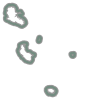

In [551]:
selected

#### Search STAC for Sentinel-2 GeoMedian Imagery

In [552]:
STAC_URL = "http://stac.digitalearthpacific.org/"
stac_client = Client.open(STAC_URL)

In [553]:
s2_search = stac_client.search(
    collections=["dep_s2_geomad"],
    intersects=selected,
    datetime=str(YEAR),
)
# Retrieve all items from search results
s2_items = s2_search.item_collection()
print("len(s2_items): ", len(s2_items))

ds_l2a= load(
    items=s2_items,
    bands=["blue", "green", "red", "rededge1", "nir08", "swir16"],
    chunks={"x": 1024, "y": 1024, "bands": -1, "time": -1},
    crs="EPSG:32759",
    resolution=10,
)
ds_l2a

len(s2_items):  5


<xarray.Dataset> Size: 6GB
Dimensions:      (y: 27166, x: 18297, time: 1)
Coordinates:
  * y            (y) float64 217kB 7.957e+06 7.957e+06 ... 7.685e+06 7.685e+06
  * x            (x) float64 146kB 2.631e+05 2.631e+05 ... 4.461e+05 4.461e+05
    spatial_ref  int32 4B 32759
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables:
    blue         (time, y, x) uint16 994MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    green        (time, y, x) uint16 994MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    red          (time, y, x) uint16 994MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    rededge1     (time, y, x) uint16 994MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    nir08        (time, y, x) uint16 994MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    swir16       (time, y, x) uint16 994MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

### Mask out open ocean and land

The **EPSG:32759** coordinate reference system for which the imagery is loaded in is characterized as follows:

**WGS 84 / UTM zone 59S**

* **Datum:** WGS84
* **Projection:** Transverse Mercator
* **Zone:** 59 south (central meridian at 171°E)
* **Units:** meters (Easting/Northing)
* **False easting:** 500,000 m
* **False northing:** 10,000,000 m (because it’s in the southern hemisphere)

Our Sentinel-2 data is in **EPSG:32759**, which means the `x` and `y` coordinates are in meters east/north from the zone’s origin.

In [555]:
# Reproject the coastal buffer to match the dataset CRS
buffer_gdf = gpd.GeoDataFrame(geometry=[selected], crs="EPSG:4326")
buffer_proj = buffer_gdf.to_crs(ds_l2a.rio.crs)

In [556]:
# Create binary mask: True = outside buffer, False = inside
mask_l2a = geometry_mask(
    geometries=[mapping(buffer_proj.iloc[0].geometry)],
    transform=ds_l2a.odc.transform,
    out_shape=(ds_l2a.sizes["y"], ds_l2a.sizes["x"]),
    invert=True  # We want True = inside the buffer
)

In [557]:
# Convert masks to DataArrays
mask_xr_l2a = xr.DataArray(
    mask_l2a,
    dims=("y", "x"),
    coords={"y": ds_l2a.y, "x": ds_l2a.x}
)

In [558]:
# mask the L1C and L2A data
ds_masked_l2a = ds_l2a.where(mask_xr_l2a)

In [559]:
ds_masked_l2a

<xarray.Dataset> Size: 12GB
Dimensions:      (time: 1, y: 27166, x: 18297)
Coordinates:
  * y            (y) float64 217kB 7.957e+06 7.957e+06 ... 7.685e+06 7.685e+06
  * x            (x) float64 146kB 2.631e+05 2.631e+05 ... 4.461e+05 4.461e+05
    spatial_ref  int32 4B 32759
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables:
    blue         (time, y, x) float32 2GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    green        (time, y, x) float32 2GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    red          (time, y, x) float32 2GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    rededge1     (time, y, x) float32 2GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    nir08        (time, y, x) float32 2GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    swir16       (time, y, x) float32 2GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

### Compute Reef Health Indicators

The **Blue-Green Index (BGI)** is a spectral index used primarily in aquatic and coastal remote sensing to help discriminate benthic habitats (like coral reefs, seagrass, sand) and assess water properties ([Bannari et al., 2022](https://os.copernicus.org/articles/18/361/2022/)). It leverages the difference between the **blue** and **green** spectral bands.

#### Formula

$$
\text{BGI} = {\text{Blue} - \text{Green}}
$$

* Calculated using surface reflectance values.


#### Interpretation of BGI values
$D$ = difference

  * **Positive** $D>0$: Blue reflectance > Green → More blue reflectance → indicates clear water, possibly healthy coral or bright sandy substrate.
  * **Negative** $D<0$: Green > Blue → often **shallow water**, **vegetation**, or **sediment** that boosts green. May suggest turbid water, algal blooms, or seagrass.
  * **Zero** $D=0$: equal blue/green reflectance.

#### How BGI helps with coral reefs

* **Differentiates benthic substrates:** Coral, seagrass, algae, sand, and bare substrate often have distinct blue and green reflectance signatures, so BGI can help separate these classes.
* **Highlights shallow water features:** Coral reefs usually occur in shallow, clear water where blue and green light penetrates well, making BGI sensitive to benthic composition.
* **Tracks changes over time:** By analyzing BGI time series, you can detect changes in reef cover, algal blooms, sedimentation, or coral bleaching events affecting reflectance.

#### Limitations and considerations

* **Scale-sensitive**: Sensitive to illumination, sensor gain, and shadows — not standardized across conditions. A difference of 0.1 at low reflectance (e.g. 0.15–0.05) is not the same "contrast" as 0.1 at high reflectance (0.80–0.70), but raw $D$ treats them identically.
* Usually masked to water pixels (e.g., using land/water masks or cloud masks).
* **Water column effects:** Water depth, turbidity, and dissolved materials affect blue and green light differently, potentially confounding BGI values.
* **Atmospheric correction needed:** Accurate surface reflectance is essential for reliable BGI values, especially over water.
* **Not a direct health measure:** BGI reflects substrate and water color but not coral health metrics like bleaching directly. It is an indirect indicator.
* **Supplement with other indices and data:** Combine BGI with other indices (e.g., NDVI for algae, bathymetry data, or hyperspectral data) for better reef monitoring.

Because the Blue Green index has such limitations, we can normalize it to make it robust to lighting changes, atmospheric variation, and sensor inconsistencies — making it more reliable for time-series analysis or cross-scene comparisons. Importantly, coral bleaching often leads to whitening, reducing pigment (chlorophyll) and increasing reflectance in the visible spectrum (especially blue and green). Chlorophyll strongly absorbs blue (~450 nm) and red (~670 nm) light for photosynthesis, so healthy coral with chlorophyll content shows low reflectance in blue and red bands. When chlorophyll content decreases (e.g., due to stress or bleaching), the absorption in the blue and red wavelengths lessens, so more light is reflected in those bands. Green reflectance is usually high already because chlorophyll reflects green (~550 nm) more than blue or red, but with reduced chlorophyll, the overall structure and pigments may change, sometimes leading to subtle changes in green reflectance as well.

The **normalized blue green index** uses a **normalized difference** of the blue and green bands to detect coral bleaching, which manifests as a spectral signature change in shallow waters. This is a form of a **Normalized Difference Index** (like NDVI), designed to highlight spectral changes in coral reefs:

$$
\text{Normalized Blue Green Index} = \frac{Blue - Green}{Blue + Green}
$$

* **Healthy coral** reflects more in the **green** spectrum and absorbs more **blue** light.
* **Bleached coral** loses pigmentation and structure, becoming brighter in **blue**, reducing the green–blue contrast.

#### Interpretation of NBGI values

* **Positive** ($0< \text{NBGI}\le1$): Blue dominates relative to total signal → likely **clearer/deeper water** or substrates with strong blue reflectance (e.g., bleached coral).
* **Negative** ($-1\le \text{NBGI}<0$): Green dominates → shallow water, benthic vegetation (seagrass, algae), or sediment.
* **Zero** ($\text{NBGI}=0$): equal contribution of blue and green.

* **Higher index values** → likely **healthy coral** (stronger green reflectance).
* **Lower index values** → potential **bleached coral** (higher blue reflectance).

#### Advantages
* **Normalized**: automatically adjusts for overall brightness—sun angle, water depth, sensor gain—so values are **directly comparable** across images and times.
* **Bounded**: easy to interpret thresholds (e.g., $\text{NBGI}<−0.2$ for dense vegetation, $\text{NBGI}>0.2$ for clear water).
* **Contrast-enhancing**: emphasizes relative difference rather than absolute magnitude.


#### Considerations:
* **Only works in shallow, clear water** — turbid water or shadows can affect accuracy.
* Requires masking **clouds**, **deep water**, and **land** first.
* You can couple it with red edge or NIR bands, or other indices like:

  * **NDVI**
  * **Red-Edge Chlorophyll Index**
  * **Turbidity Index** (Blue/SWIR)

In [560]:
def compute_nbgi(ds):
    return (ds["blue"] - ds["green"]) / (ds["blue"] + ds["green"])  # Simplified spectral ratio

In [561]:
nbgi = compute_nbgi(ds_masked_l2a)

In [562]:
# Check output ranges
vals = nbgi.values
vals_clean = vals[np.isfinite(vals)]

#print("Unique:", np.unique(vals_clean))
print("Min:", vals_clean.min())
print("Max:", vals_clean.max())

Min: -0.4302462
Max: 0.34035826


In [563]:
# Visualize corrected BGI
#nbgi.hvplot.image(x="x", y="y", cmap="viridis", width=600, height=400)

In [564]:
#nbgi.rio.to_raster(f"nbgi_{PROVINCE}_{DATERANGE_START}_{DATERANGE_END}.tif")

### Coral reef outline integration and clipping

We will use a benthic polygon dataset provided by Allen Coral Atlas to clip our NBGI imagery, so as to focus on this index in the context of coral reefs.

Citation:

Allen Coral Atlas maps, bathymetry and map statistics are © 2018-2023 Allen Coral Atlas Partnership and Arizona State University and licensed CC BY 4.0 (https://creativecommons.org/licenses/by/4.0/)

Let's download a subset from the [Allen Coral Atlas](https://allencoralatlas.org/) for Vanuatu.

In [566]:
!gdown "https://drive.google.com/uc?id=1Yzl12h9N6bERnCU12kDg7s2OIr01WCwC"

In [567]:
benthic_gdf = gpd.read_file('benthic_vanuatu_allen_full.geojson') #'benthic.geojson')

In [568]:
benthic_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Reproject the benthic dtaasret to the same CRS as our imagery.

In [569]:
benthic_gdf_rp = benthic_gdf.to_crs(epsg=nbgi.rio.crs.to_epsg())

In [570]:
benthic_gdf.columns

Index(['class', 'geometry'], dtype='object')

In [571]:
benthic_gdf["class"].unique()

array(['Rock', 'Coral/Algae', 'Sand', 'Microalgal Mats', 'Rubble',
       'Seagrass'], dtype=object)

Filter for only coral polygons.

In [572]:
benthic_gdf["class_int"] = (benthic_gdf["class"] == "Coral/Algae").astype(int)

In [573]:
benthic_gdf.class_int.unique()

array([0, 1])

Get the polygons for the focus province.

In [575]:
width, height = nbgi.x.size, nbgi.y.size

benthic_gdf_rp = benthic_gdf.to_crs(epsg=nbgi.rio.crs.to_epsg())

# Define the resolution and bounds based on NBGI features
resolution = nbgi.rio.resolution()
bounds_test = nbgi.rio.bounds()

raster_bounds = box(*nbgi.rio.bounds())
benthic_gdf_select = benthic_gdf_rp[benthic_gdf_rp.intersects(raster_bounds)]

print(f"Before: {len(benthic_gdf_rp)} | After: {len(benthic_gdf_select)}")

Before: 100364 | After: 12435


Clip the NBGI imagery to the extent of the coral reefs.

In [576]:
# Clip using polygons
nbgi_clipped = nbgi.rio.clip(benthic_gdf_rp.geometry, benthic_gdf_rp.crs, drop=True, all_touched=True)

# Check output ranges
vals = nbgi_clipped.values
vals_clean = vals[np.isfinite(vals)]

#print("Unique:", np.unique(vals_clean))
print("Min:", vals_clean.min())
print("Max:", vals_clean.max())

Min: -0.3052234
Max: 0.2701252


Save to a Cloud Optimized GeoTIFF.

In [ ]:
# Write to GeoTIFF
output_path = f"nbgi_clipped_{PROVINCE}_{YEAR}.tif"

nbgi_clipped.rio.to_raster(
    output_path,
    driver="COG",
    compress="deflate",     # good balance of speed and size
    blockxsize=1024,
    blockysize=1024,
    tiled=True,
    overview_resampling="nearest",  # builds overviews for fast cloud reads
)

print(f"Saved clipped raster to {output_path}")